In [298]:
!pip install yfinance
!pip install matplotlib
!pip install scikit-learn
import sklearn
import matplotlib 
import yfinance as yf

In [299]:
sp500 = yf.Ticker("^GSPC")

In [300]:
sp500 = sp500.history(period='max')

In [301]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-09-18 00:00:00-04:00', '2025-09-19 00:00:00-04:00',
               '2025-09-22 00:00:00-04:00', '2025-09-23 00:00:00-04:00',
               '2025-09-24 00:00:00-04:00', '2025-09-25 00:00:00-04:00',
               '2025-09-26 00:00:00-04:00', '2025-09-29 00:00:00-04:00',
               '2025-09-30 00:00:00-04:00', '2025-10-01 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24554, freq=None)

<Axes: xlabel='Date'>

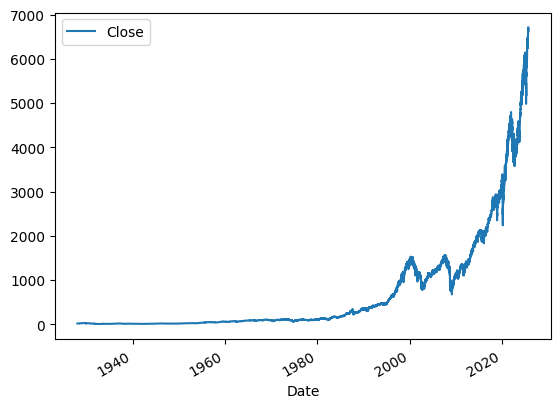

In [302]:
sp500.plot.line(y="Close", use_index=True)

In [303]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [304]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [305]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [306]:
sp500 = sp500.loc["1990-01-01":].copy()

In [307]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2025-09-25 00:00:00-04:00,6608.189941,6619.000000,6569.220215,6604.720215,5874670000,6643.700195,1
2025-09-26 00:00:00-04:00,6615.379883,6648.970215,6604.430176,6643.700195,5103110000,6661.209961,1
2025-09-29 00:00:00-04:00,6661.580078,6677.310059,6644.490234,6661.209961,5358760000,6688.459961,1


In [308]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [309]:
RandomForestClassifier(min_samples_split=100, random_state=1)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [310]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [311]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [312]:
precision_score(test["Target"], preds)

0.6

In [313]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

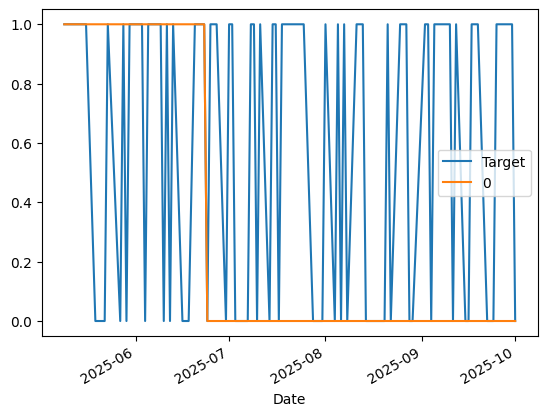

In [314]:
combined.plot()

In [315]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [316]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [317]:
predictions = backtest(sp500, model, predictors)

In [318]:
predictions["Predictions"].value_counts()

Predictions
0    3838
1    2666
Name: count, dtype: int64

In [319]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5300075018754689

In [320]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.5369
0    0.4631
Name: count, dtype: float64

In [321]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [322]:
sp500 = sp500.dropna()

In [323]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-24 00:00:00-04:00,6669.790039,6672.660156,6621.759766,6637.970215,5459180000,6604.720215,0,0.998575,0.0,0.997143,3.0,1.035088,33.0,1.110123,140.0,1.365761,530.0
2025-09-25 00:00:00-04:00,6608.189941,6619.000000,6569.220215,6604.720215,5874670000,6643.700195,1,0.997489,0.0,0.992960,2.0,1.028816,33.0,1.103910,140.0,1.358278,530.0
2025-09-26 00:00:00-04:00,6615.379883,6648.970215,6604.430176,6643.700195,5103110000,6661.209961,1,1.002942,1.0,0.999442,2.0,1.033770,33.0,1.109759,140.0,1.365652,530.0


In [324]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [325]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [326]:
predictions = backtest(sp500, model, new_predictors)

In [327]:
predictions["Predictions"].value_counts()

Predictions
0.0    4632
1.0     871
Name: count, dtype: int64

In [328]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5717566016073479